
# 🌿 Content‑Based Recommenders — **Benchmark**

**Metode yang dibandingkan:**
1. **TF‑IDF (word) + cosine** — baseline cepat untuk query berbasis kata kunci.  
2. **TF‑IDF + UFW (User Feedback Weighting)** — personalisasi ringan via **centroid Like** (tanpa user login).  
3. **LSI / TruncatedSVD (dense) + cosine** — proyeksi ke ruang topik laten untuk toleransi semantik ringan.

**Output utama:** metrik **P@1, Recall@10, MRR, nDCG@10, Latency**, tabel + visual; serta **artefak** (vectorizer, matriks, SVD, metrics.csv).

---


In [1]:
# !pip -q install -U pandas numpy scipy scikit-learn joblib matplotlib seaborn


## 1) Imports & Konfigurasi

In [2]:
import os, re, math, json, random, warnings, datetime as dt, time
from pathlib import Path
from typing import List, Optional, Dict

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
sns.set_theme(style="whitegrid")

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import GroupShuffleSplit

from scipy.sparse import save_npz
import joblib

SEED = 42
random.seed(SEED); np.random.seed(SEED)

BASE_DIR = Path(".")
ART_DIR  = BASE_DIR / "artifacts_cbf_bench_3"
ART_DIR.mkdir(exist_ok=True, parents=True)
print("Artifacts dir:", ART_DIR.resolve())

Artifacts dir: /content/artifacts_cbf_bench_3



## 2) Load Data

Notebook akan mencari salah satu dari:
- `./items.csv`
- `./artifacts/items.csv`
- `./eco_place.csv`

**Kolom minimal**: `place_name, place_description, category, city` (opsional: `rating, price, place_img, place_map`).


In [3]:
CANDIDATES = [Path("./items.csv"), Path("./artifacts/items.csv"), Path("./eco_place.csv")]
data_path = None
for p in CANDIDATES:
    if p.exists():
        data_path = p; break
if data_path is None:
    raise FileNotFoundError("Tidak menemukan items.csv / artifacts/items.csv / eco_place.csv. Upload salah satunya.")

df = pd.read_csv(data_path)
print("Loaded:", data_path, "| Shape:", df.shape)

# Pastikan kolom
for c in ["place_name","place_description","category","city","rating","price","place_img","place_map"]:
    if c not in df.columns: df[c] = np.nan

# Preprocess ringan: lowercase + filter stopwords, pertahankan preposisi penting
STOP = set([
    "ada","adalah","agar","akan","antara","atau","banyak","beberapa","belum","berbagai",
    "bila","bisa","bukan","dalam","dan","dapat","dari","dengan","di","hanya","harus","hingga",
    "ini","itu","jika","juga","kah","kami","kamu","karena","ke","kemudian","kepada","lah","lain",
    "lainnya","lalu","lebih","masih","mereka","mungkin","namun","nya","oleh","pada","para","pernah",
    "pun","saat","saja","sampai","sangat","sebagai","sebuah","seluruh","semua","serta","setiap",
    "suatu","sudah","supaya","tanpa","tapi","tentang","tentu","terhadap","tiap","untuk","yaitu","yakni","yang"
])
KEEP = {"di","ke","dari","untuk","dengan","yang"}

def preprocess_text_simple(text: str) -> str:
    text = str(text).lower()
    toks = re.findall(r"\w+", text)
    toks = [t for t in toks if (t not in STOP) or (t in KEEP)]
    return " ".join(toks)

# isi kosong & buat kolom gabungan
df["place_description"] = df["place_description"].fillna("").astype(str)
df["category"]          = df["category"].fillna("").astype(str)
df["city"]              = df["city"].fillna("").astype(str)
df["place_name"]        = df["place_name"].fillna("").astype(str)

if "gabungan" not in df.columns:
    df["gabungan"] = (df["place_description"] + " " + df["category"] + " " + df["city"]).apply(preprocess_text_simple)
else:
    df["gabungan"] = df["gabungan"].fillna("").astype(str).apply(preprocess_text_simple)

print(df[["place_name","category","city","gabungan"]].head(3))
N_ITEMS = len(df)


Loaded: items.csv | Shape: (182, 8)
                     place_name               category  city  \
0  Taman Nasional Gunung Leuser  Budaya,Taman Nasional  Aceh   
1            Desa Wisata Munduk            Desa Wisata  Bali   
2       Desa Wisata Penglipuran     Budaya,Desa Wisata  Bali   

                                            gabungan  
0  taman nasional gunung leuser salah satu dari e...  
1  desa wisata munduk desa di pegunungan bali yan...  
2  desa wisata penglipuran desa wisata yang terle...  



## 3) EDA Komprehensif (Teks & Visual)

Statistik ringkas dan visual: distribusi rating/harga, top‑kategori/kota, panjang teks, korelasi numerik, dan contoh item.


Jumlah item: 182

Missing values per column:
place_name           0
place_description    0
category             0
city                 0
rating               0
price                0
dtype: int64

Stat panjang deskripsi:
       desc_len
count     182.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0

Stat panjang gabungan:
       gabungan_len
count    182.000000
mean     418.456044
std      167.699632
min      119.000000
25%      303.000000
50%      384.000000
75%      512.750000
max      963.000000


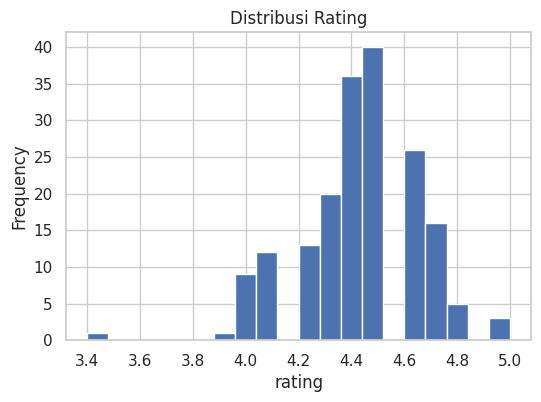

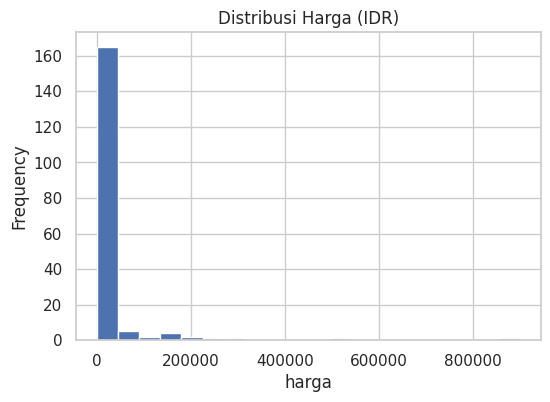

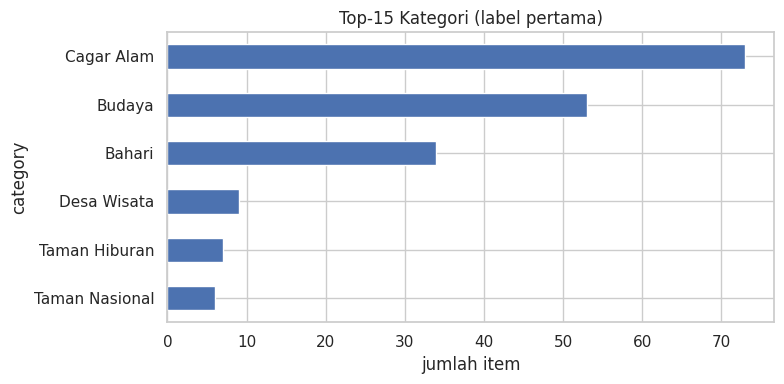

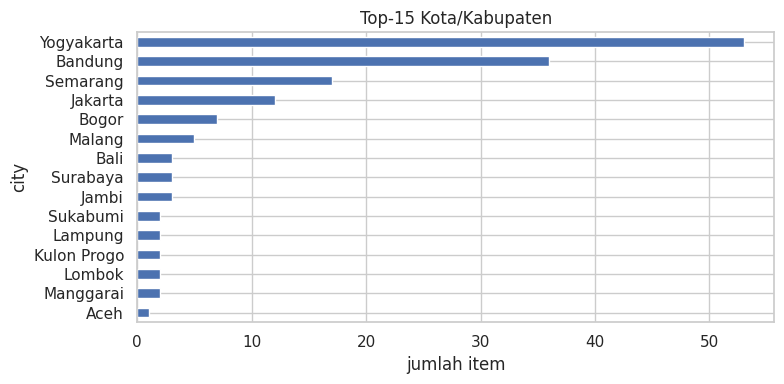

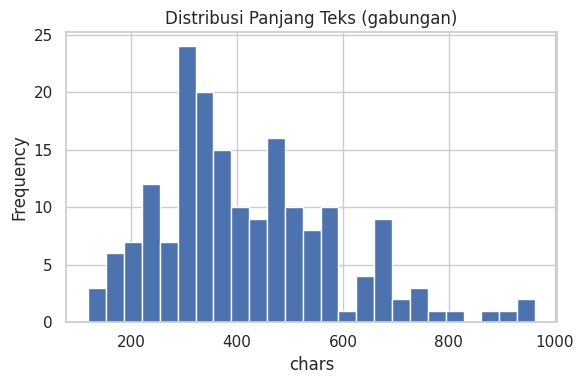

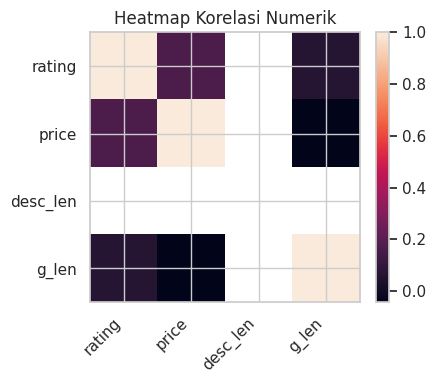

\nContoh 3 item acak:


,place_name,category,city,rating,price
19,Jendela Alam,Taman Hiburan,Bandung,4.4,20000.0
42,Kawah Ijen,"Cagar Alam,Taman Nasional",Banyuwangi,4.7,7500.0
154,Pantai Greweng,"Bahari,Cagar Alam",Yogyakarta,4.6,5000.0


In [4]:
# Ringkasan numerik
print("Jumlah item:", len(df))
print("\nMissing values per column:")
print(df[["place_name","place_description","category","city","rating","price"]].isna().sum())

# Feature panjang teks
df["desc_len"] = df["place_description"].astype(str).str.len()
df["g_len"]    = df["gabungan"].astype(str).str.len()

print("\nStat panjang deskripsi:")
print(df["desc_len"].describe().to_frame("desc_len"))
print("\nStat panjang gabungan:")
print(df["g_len"].describe().to_frame("gabungan_len"))

# Visuals — seaborn/matplotlib (ggplot style)
fig, ax = plt.subplots(figsize=(6,4))
pd.to_numeric(df["rating"], errors="coerce").plot(kind="hist", bins=20, ax=ax, title="Distribusi Rating")
ax.set_xlabel("rating"); plt.show()

fig, ax = plt.subplots(figsize=(6,4))
pd.to_numeric(df["price"], errors="coerce").plot(kind="hist", bins=20, ax=ax, title="Distribusi Harga (IDR)")
ax.set_xlabel("harga"); plt.show()

# Top kategori
cat1 = df["category"].fillna("").apply(lambda s: str(s).split(",")[0].strip())
top_cat = cat1.value_counts().head(15)
fig, ax = plt.subplots(figsize=(8,4))
top_cat.sort_values(ascending=True).plot(kind="barh", ax=ax, title="Top-15 Kategori (label pertama)")
ax.set_xlabel("jumlah item"); plt.tight_layout(); plt.show()

# Top kota
top_city = df["city"].fillna("").str.strip().value_counts().head(15)
fig, ax = plt.subplots(figsize=(8,4))
top_city.sort_values(ascending=True).plot(kind="barh", ax=ax, title="Top-15 Kota/Kabupaten")
ax.set_xlabel("jumlah item"); plt.tight_layout(); plt.show()

# Panjang gabungan
fig, ax = plt.subplots(figsize=(6,4))
df["g_len"].plot(kind="hist", bins=25, ax=ax, title="Distribusi Panjang Teks (gabungan)")
ax.set_xlabel("chars"); plt.tight_layout(); plt.show()

# Korelasi numerik
num_cols = [c for c in ["rating","price","desc_len","g_len"] if c in df.columns]
if len(num_cols) >= 2:
    corr = df[num_cols].corr(numeric_only=True)
    fig, ax = plt.subplots(figsize=(5,4))
    im = ax.imshow(corr, interpolation='nearest')
    ax.set_title("Heatmap Korelasi Numerik")
    ax.set_xticks(range(len(num_cols))); ax.set_xticklabels(num_cols, rotation=45, ha='right')
    ax.set_yticks(range(len(num_cols))); ax.set_yticklabels(num_cols)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout(); plt.show()

# Contoh item acak
from IPython.display import display
print("\\nContoh 3 item acak:")
display(df.sample(min(3, len(df)))[["place_name","category","city","rating","price"]])


## 4) Query Sintetis & Split Aman per‑Item

Dua bentuk query per item:
- **q_struct_1:** `"kategori_kunci kota nama"`
- **q_struct_2:** `"wisata {kategori} di {kota}"`

Split menggunakan **GroupShuffleSplit** (group=item) untuk mencegah kebocoran.


In [5]:
def q_struct_1(r: pd.Series) -> str:
    cat  = str(r.get("category","")).split(",")[0].strip()
    city = str(r.get("city","")).strip()
    name = str(r.get("place_name","")).strip()
    toks = [t for t in [cat, city, name] if t]
    return " ".join(toks)

def q_struct_2(r: pd.Series) -> str:
    cat  = str(r.get("category","")).split(",")[0].strip().lower()
    city = str(r.get("city","")).strip().lower()
    base = "wisata"
    if cat:  base += f" {cat}"
    if city: base += f" di {city}"
    return base.strip()

pairs = []
for i, r in df.iterrows():
    for q in (q_struct_1(r), q_struct_2(r)):
        if q and len(q) >= 3:
            pairs.append((q, int(i)))

random.shuffle(pairs)
print("Total pairs:", len(pairs))

MAX_Q = 500
pairs = pairs[:MAX_Q] if MAX_Q else pairs

q_texts = np.array([preprocess_text_simple(q) for q,_ in pairs], dtype=object)
y_idx   = np.array([idx for _,idx in pairs], dtype=np.int64)

# split per-group
gss1 = GroupShuffleSplit(n_splits=1, test_size=0.30, random_state=42)
train_idx, tmp_idx = next(gss1.split(q_texts, y_idx, groups=y_idx))

gss2 = GroupShuffleSplit(n_splits=1, test_size=0.50, random_state=42)
val_rel_idx, test_rel_idx = next(gss2.split(q_texts[tmp_idx], y_idx[tmp_idx], groups=y_idx[tmp_idx]))
val_idx  = tmp_idx[val_rel_idx]
test_idx = tmp_idx[test_rel_idx]

Q_train, y_train = q_texts[train_idx].tolist(), y_idx[train_idx]
Q_val,   y_val   = q_texts[val_idx].tolist(),   y_idx[val_idx]
Q_test,  y_test  = q_texts[test_idx].tolist(),  y_idx[test_idx]

print("Split sizes -> Train:", len(Q_train), "Val:", len(Q_val), "Test:", len(Q_test))


Total pairs: 364
Split sizes -> Train: 254 Val: 54 Test: 56



## 5) Fitur & Indeks (TF‑IDF, SVD) + Centroid untuk UFW


In [6]:
art = {}

# Siapkan korpus aman (fallback bila 'gabungan' kosong habis preprocessing)
corpus = df["gabungan"].fillna("").astype(str)
if not np.any(corpus.str.strip().values):  # semua kosong -> fallback dari kolom lain
    def _mk_fallback(row):
        parts = [row.get("place_name",""), row.get("category",""), row.get("city","")]
        return " ".join([str(p).strip() for p in parts if str(p).strip()])
    corpus = df.apply(_mk_fallback, axis=1).astype(str).str.lower()

# TF‑IDF (word) dengan fallback bila vocabulary kosong
try:
    vec_word = TfidfVectorizer(
        max_features=12000, ngram_range=(1,2),
        min_df=2, max_df=0.95, sublinear_tf=True, norm='l2'
    )
    X_tfidf_word = vec_word.fit_transform(corpus)
except ValueError as e:
    if "empty vocabulary" in str(e):
        vec_word = TfidfVectorizer(
            max_features=20000, ngram_range=(1,2),
            min_df=1, max_df=1.0, sublinear_tf=True, norm='l2'
        )
        X_tfidf_word = vec_word.fit_transform(corpus)
    else:
        raise

# Simpan artefak TF‑IDF
save_npz(ART_DIR / "tfidf_word.npz", X_tfidf_word.tocsr())
joblib.dump(vec_word, ART_DIR / "vectorizer_word.joblib")
art["tfidf_word"] = (vec_word, X_tfidf_word)

# LSI / SVD
n_features = X_tfidf_word.shape[1]
n_comp = int(min(256, max(2, n_features - 1)))  # >=2 dan < n_features
svd = TruncatedSVD(n_components=n_comp, random_state=42)
X_lsi = svd.fit_transform(X_tfidf_word).astype("float32")

joblib.dump(svd, ART_DIR / "svd.joblib")
np.save(ART_DIR / "X_lsi.npy", X_lsi)
art["lsi"] = (svd, X_lsi)

# UFW centroid
cat_first = df["category"].fillna("").apply(lambda s: str(s).split(",")[0].strip())
vc = cat_first[cat_first != ""].value_counts()
dom_cat = vc.index[0] if not vc.empty else ""

seed_size = max(3, min(10, max(1, len(df)//10)))
LIKED_IDX = df.index[cat_first == dom_cat].tolist()[:seed_size]
if len(LIKED_IDX) == 0:
    LIKED_IDX = list(range(min(seed_size, len(df))))

TFIDF_DENSE = X_tfidf_word.astype("float32").toarray()

def _centroid(indices: List[int]) -> Optional[np.ndarray]:
    if not indices:
        return None
    C = TFIDF_DENSE[indices].mean(axis=0, keepdims=True)
    n = np.linalg.norm(C) + 1e-9
    return C / n

CENT = _centroid(LIKED_IDX)

print(
    f"TF-IDF: {X_tfidf_word.shape}, SVD(n_comp={n_comp}): {X_lsi.shape} | "
    f"Centroid available: {CENT is not None} | liked seed size: {len(LIKED_IDX)}"
)


TF-IDF: (182, 1746), SVD(n_comp=256): (182, 182) | Centroid available: True | liked seed size: 10


## 6) Rankers

In [7]:
def scores_tfidf_word(q: str) -> np.ndarray:
    vec, X = art["tfidf_word"]
    qv = vec.transform([q])
    s  = cosine_similarity(X, qv)[:,0]
    return s

def scores_lsi(q: str) -> np.ndarray:
    vec, Xw = art["tfidf_word"]
    svd, Il = art["lsi"]
    qv = vec.transform([q])
    ql = svd.transform(qv).astype("float32")
    # cosine manual
    s  = (Il @ ql.T).ravel() / (np.linalg.norm(Il, axis=1) * (np.linalg.norm(ql) + 1e-9) + 1e-9)
    return s

def scores_tfidf_ufw(q: str, alpha: float = 0.6) -> np.ndarray:
    base = scores_tfidf_word(q)
    if CENT is None:
        return base
    denom = (np.linalg.norm(TFIDF_DENSE, axis=1) + 1e-9) * (np.linalg.norm(CENT) + 1e-9)
    simc  = (TFIDF_DENSE @ CENT.T).ravel() / denom
    return base + alpha * simc

METHODS: Dict[str, callable] = {
    "TFIDF(word) cosine": scores_tfidf_word,
    "TFIDF + UFW(α=0.6)": lambda q: scores_tfidf_ufw(q, alpha=0.6),
    "LSI(SVD) cosine":   scores_lsi,
}
list(METHODS.keys())


['TFIDF(word) cosine', 'TFIDF + UFW(α=0.6)', 'LSI(SVD) cosine']

## 7) Metrik, Evaluasi & Visualisasi

,Method,P@1,Recall@10,MRR,nDCG@10,Latency(ms/q)
0,TFIDF(word) cosine,0.388889,0.703704,0.519139,0.552855,3.587690
1,LSI(SVD) cosine,0.388889,0.703704,0.519139,0.552855,0.736298
2,TFIDF + UFW(α=0.6),0.296296,0.592593,0.401128,0.435171,3.243883


,Method,P@1,Recall@10,MRR,nDCG@10,Latency(ms/q)
0,TFIDF(word) cosine,0.285714,0.714286,0.417151,0.478381,1.224825
1,LSI(SVD) cosine,0.285714,0.714286,0.417151,0.478381,0.961725
2,TFIDF + UFW(α=0.6),0.232143,0.446429,0.310841,0.323517,1.640835


/tmp/ipython-input-747080688.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_title(title); ax.set_ylabel(metric); ax.set_xticklabels(df["Method"], rotation=20, ha="right")


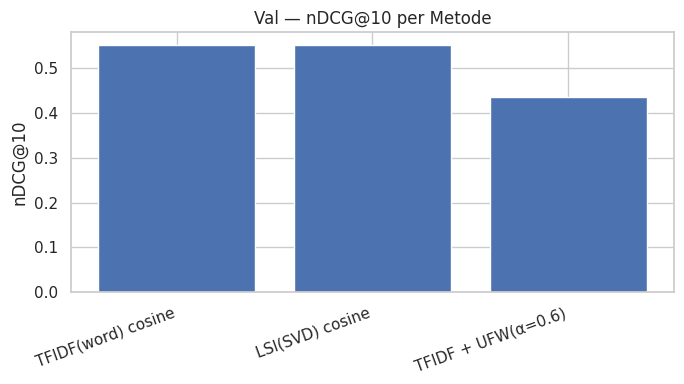

/tmp/ipython-input-747080688.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_title(title); ax.set_ylabel(metric); ax.set_xticklabels(df["Method"], rotation=20, ha="right")


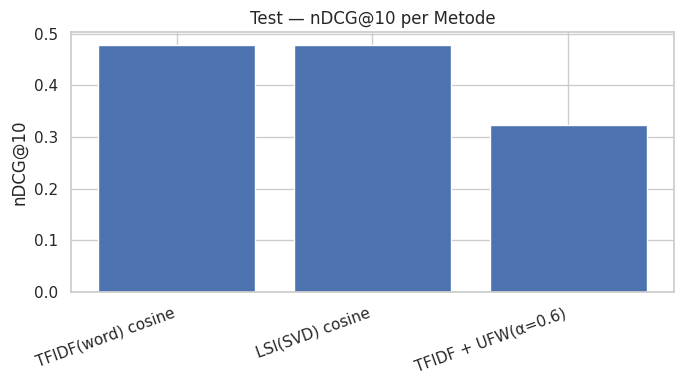

/tmp/ipython-input-747080688.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_title(title); ax.set_ylabel(metric); ax.set_xticklabels(df["Method"], rotation=20, ha="right")


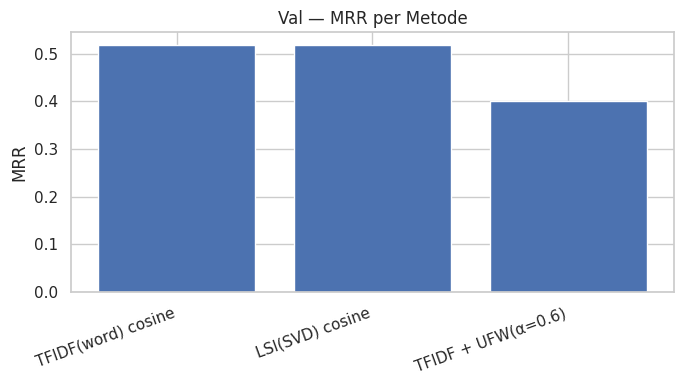

/tmp/ipython-input-747080688.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_title(title); ax.set_ylabel(metric); ax.set_xticklabels(df["Method"], rotation=20, ha="right")


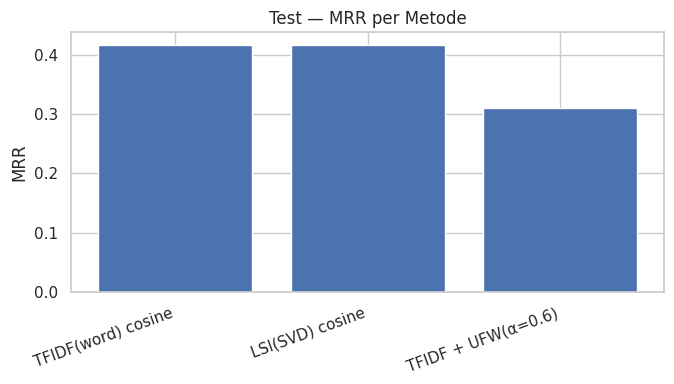

/tmp/ipython-input-747080688.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_title(title); ax.set_ylabel(metric); ax.set_xticklabels(df["Method"], rotation=20, ha="right")


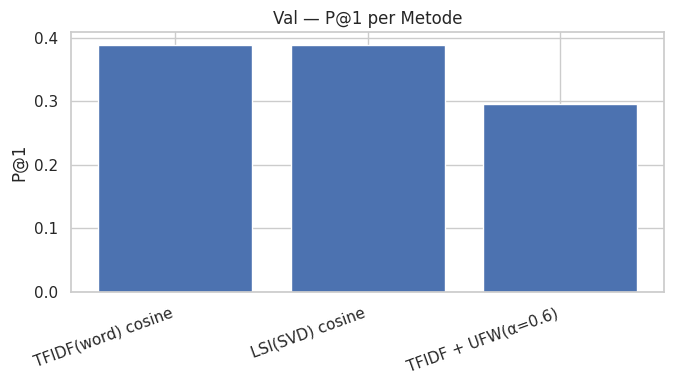

/tmp/ipython-input-747080688.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_title(title); ax.set_ylabel(metric); ax.set_xticklabels(df["Method"], rotation=20, ha="right")


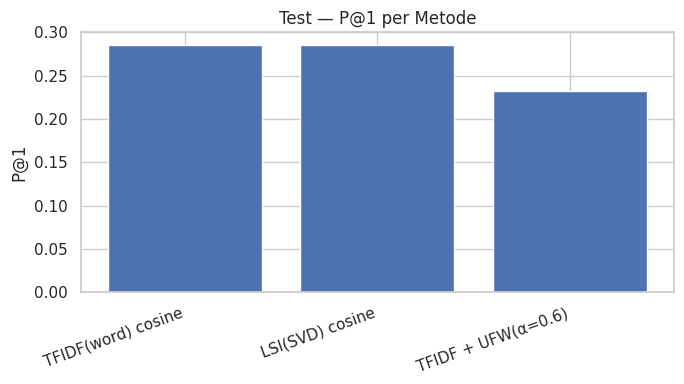

/tmp/ipython-input-747080688.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_title(title); ax.set_ylabel(metric); ax.set_xticklabels(df["Method"], rotation=20, ha="right")


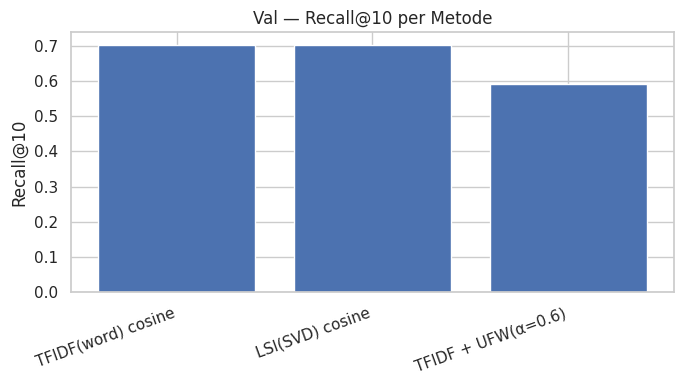

/tmp/ipython-input-747080688.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_title(title); ax.set_ylabel(metric); ax.set_xticklabels(df["Method"], rotation=20, ha="right")


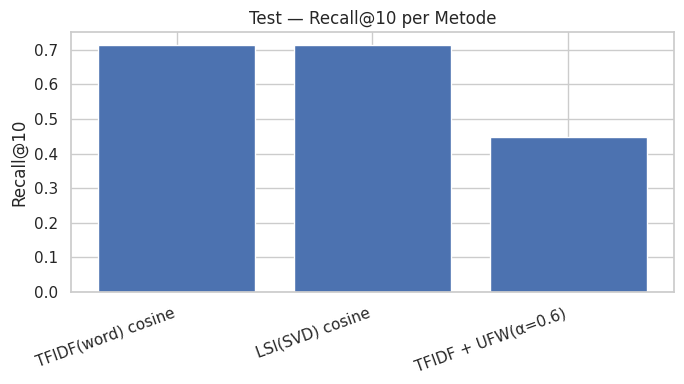

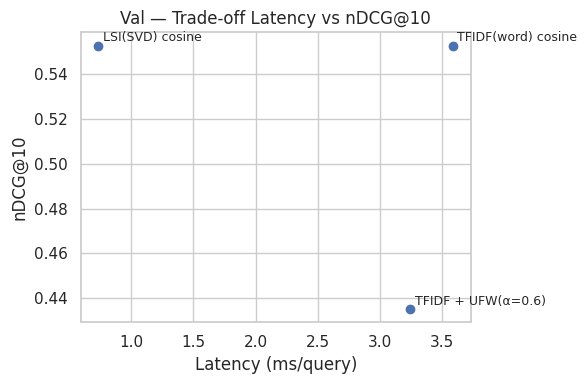

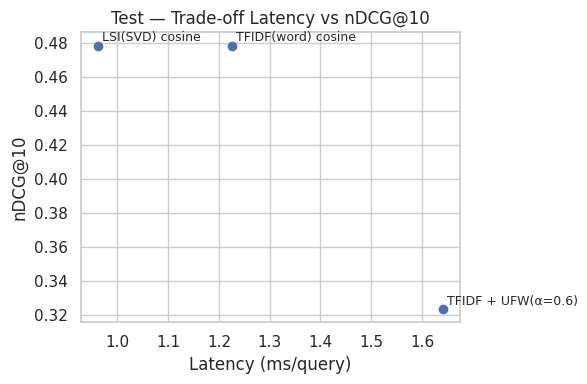

Saved: artifacts_cbf_bench_3/metrics_val.csv | artifacts_cbf_bench_3/metrics_test.csv


In [8]:
import math, time

def precision_at_k(rank: List[int], gt: int, k: int=1) -> float:
    return 1.0 if gt in rank[:k] else 0.0

def recall_at_k(rank: List[int], gt: int, k: int=10) -> float:
    return 1.0 if gt in rank[:k] else 0.0

def mrr(rank: List[int], gt: int) -> float:
    try:
        pos = rank.index(gt); return 1.0 / float(pos + 1)
    except ValueError:
        return 0.0

def ndcg_at_k(rank: List[int], gt: int, k: int=10) -> float:
    try:
        pos = rank[:k].index(gt); return 1.0 / math.log2(pos + 2)
    except ValueError:
        return 0.0

def evaluate_methods(Q_list: List[str], y_true: np.ndarray, methods=METHODS, topk: int=10):
    rows = []
    for name, fn in methods.items():
        t0 = time.perf_counter()
        p1 = r10 = m = nd = 0.0
        for q, gt in zip(Q_list, y_true):
            s = fn(q)
            rank = np.argsort(-s).tolist()
            p1  += precision_at_k(rank, int(gt), 1)
            r10 += recall_at_k(rank, int(gt), 10)
            m   += mrr(rank, int(gt))
            nd  += ndcg_at_k(rank, int(gt), 10)
        ms_per_q = (time.perf_counter() - t0) * 1000.0 / max(1, len(Q_list))
        n = float(len(Q_list))
        rows.append({
            "Method": name,
            "P@1": p1/n, "Recall@10": r10/n, "MRR": m/n, "nDCG@10": nd/n,
            "Latency(ms/q)": ms_per_q
        })
    res = pd.DataFrame(rows).sort_values("nDCG@10", ascending=False).reset_index(drop=True)
    return res

res_val  = evaluate_methods(Q_val,  y_val)
res_test = evaluate_methods(Q_test, y_test)

from IPython.display import display
display(res_val); display(res_test)

# Visualisasi
def plot_metric_bars(df, metric:str, title:str):
    fig, ax = plt.subplots(figsize=(7,4))
    ax.bar(df["Method"], df[metric])
    ax.set_title(title); ax.set_ylabel(metric); ax.set_xticklabels(df["Method"], rotation=20, ha="right")
    plt.tight_layout(); plt.show()

for m in ["nDCG@10","MRR","P@1","Recall@10"]:
    plot_metric_bars(res_val,  m, f"Val — {m} per Metode")
    plot_metric_bars(res_test, m, f"Test — {m} per Metode")

def plot_latency_tradeoff(df, split_name):
    fig, ax = plt.subplots(figsize=(6,4))
    ax.scatter(df["Latency(ms/q)"], df["nDCG@10"])
    for _,row in df.iterrows():
        ax.annotate(row["Method"], (row["Latency(ms/q)"], row["nDCG@10"]), fontsize=9, xytext=(3,3), textcoords="offset points")
    ax.set_title(f"{split_name} — Trade‑off Latency vs nDCG@10")
    ax.set_xlabel("Latency (ms/query)"); ax.set_ylabel("nDCG@10")
    plt.tight_layout(); plt.show()

plot_latency_tradeoff(res_val,  "Val")
plot_latency_tradeoff(res_test, "Test")

# Simpan metrics
res_val.assign(Split="Val").to_csv(ART_DIR / "metrics_val.csv", index=False)
res_test.assign(Split="Test").to_csv(ART_DIR / "metrics_test.csv", index=False)
print("Saved:", (ART_DIR / "metrics_val.csv").as_posix(), "|", (ART_DIR / "metrics_test.csv").as_posix())


## 8) Simpan Artefak & Demo Top‑K

In [9]:
meta = {
    "created_at": dt.datetime.utcnow().isoformat() + "Z",
    "seed": 42,
    "methods": ["TFIDF(word) cosine","TFIDF + UFW(α=0.6)","LSI(SVD) cosine"],
    "tfidf": {"max_features": 12000, "ngram_range": [1,2], "min_df": 2, "max_df": 0.95},
    "svd": {"n_components": int(min(256, max(2, art['lsi'][0].n_components)))}
}
with open(ART_DIR / "meta.json","w") as f:
    json.dump(meta, f, indent=2)
print("Saved meta in:", ART_DIR.resolve())

def retrieve_demo(q: str, k: int = 5, method: str = "TFIDF(word) cosine"):
    fn = METHODS[method]
    s  = fn(q)
    order = np.argsort(-s)[:k]
    return list(zip(order.tolist(), np.asarray(s)[order].tolist()))

print("Demo:", retrieve_demo("pantai snorkeling aceh", k=5, method="TFIDF(word) cosine"))


Saved meta in: /content/artifacts_cbf_bench_3
Demo: [(89, 0.18385082346924136), (171, 0.17549633859855146), (160, 0.16750785054153483), (60, 0.1435226339284774), (169, 0.1390203340956443)]


/tmp/ipython-input-2638954045.py:2: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "created_at": dt.datetime.utcnow().isoformat() + "Z",



## 9) Justifikasi & Rekomendasi

**Mengapa 3 metode ini?**
- **TF‑IDF (word) + cosine** → baseline cepat, kuat untuk query kata kunci, mudah dituning.  
- **TF‑IDF + UFW** → personalisasi ringan berbasis Like/Skip; sering meningkatkan MRR/nDCG dengan biaya komputasi minimal.  
- **LSI / TruncatedSVD** → menangkap topik laten & sinonimi ringan; vektor dense ideal untuk ANN saat skala besar.

**Tips produksi**: tambah MMR untuk diversifikasi, terapkan aturan bisnis (harga/lokasi), cache embedding, pantau P95 latensi, dan A/B test (nDCG@K/CTR).
